In [1]:
from cmath import exp
from math import pi

import kwant
from matplotlib import pyplot

Code modified from example: ab_ring.py

Here we study transport through a quantum ring that is pierced by a magnetic flux $\phi$

In [2]:
def make_system(a=1, t=1.0, W=10, r1=10, r2=20):
    
    lat = kwant.lattice.square(a)
    
    syst = kwant.Builder()
    
    def ring(pos):
        (x, y) = pos
        rsq = x **2 + y ** 2
        return (r1 ** 2 < rsq < r2 ** 2)

    syst[lat.shape(ring,(0, r1 +1))] = 4 * t
    syst[lat.neighbors()] = -t
    
    # In order to introduce a flux through the ring, we introduce a phase on
    # the hoppings on the line cut through one of the arms.  Since we want to
    # change the flux without modifying the Builder instance repeatedly, we
    # define the modified hoppings as a function that takes the flux as its
    # parameter phi.
    def hopping_phase(site1, site2, phi):
        return -t * exp(1j* phi)
    
    def crosses_branchcut(hop):
        ix0, iy0 = hop[0].tag
        # builder.HoppingKind with the argument (1, 0) below
        # returns hoppings ordered as ((i+1, j), (i, j))
        return iy0 < 0 and ix0 == 1  # ix1 == 0 then implied
    
    def hops_across_cut(syst):
        for hop in kwant.builder.HoppingKind((1, 0), lat, lat)(syst):
            if crosses_branchcut(hop):
                yield hop
    
    syst[hops_across_cut] = hopping_phase
    
    sym_lead = kwant.TranslationalSymmetry((-a, 0))
    lead = kwant.Builder(sym_lead)
    
    def lead_shape(pos):
        (x, y) = pos
        return (-W / 2 < y < W / 2)
    
    lead[lat.shape(lead_shape, (0, 0))] = 4 * t
    lead[lat.neighbors()] = -t
    
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    
    return syst

In [3]:
def plot_conductance(syst, energy, fluxes):
    # compute conductance

    normalized_fluxes = [flux / (2 * pi) for flux in fluxes]
    data = []
    for flux in fluxes:
        smatrix = kwant.smatrix(syst, energy, args=[flux])
        data.append(smatrix.transmission(1, 0))

    pyplot.figure()
    pyplot.plot(normalized_fluxes, data)
    pyplot.xlabel("flux [flux quantum]")
    pyplot.ylabel("conductance [e^2/h]")
    pyplot.show()

In [4]:
def main():
    syst = make_system()

    # Check that the system looks as intended.
    kwant.plot(syst)

    # Finalize the system.
    syst = syst.finalized()

    # We should see a conductance that is periodic with the flux quantum
    plot_conductance(syst, energy=0.15, fluxes=[0.01 * i * 3 * 2 * pi for i in range(100)])

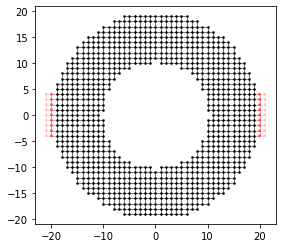

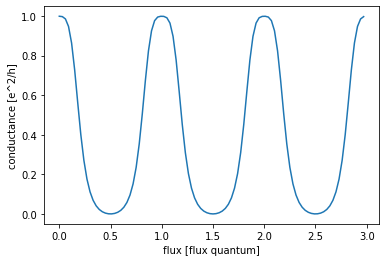

In [5]:
main()